In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F

# Clasificación II

> Autor: Jorge García González (Universidad de Málaga)

> Última Actualización: 22/10/2025

> Asignatura: Programación para la Inteligencia Artificial

En el cuaderno anterior hemos abordado el problema de clasificación binaria. Ahora vamos a centrarnos en el caso más general, asumir que hay un conjunto de clases $C$ tal que $|C|>=2$.

Antes de nada, vamos a volver a crear los conjuntos de entrenamiento, validación y test. Ahora lo vamos a hacer con más clases del conjunto MNIST.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
workpath = '/content/drive/MyDrive/Work/Docencia UMA/2025-2026/Programacion para la IA/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dataset = datasets.MNIST(root=workpath, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root=workpath, train=False, download=True, transform=transforms.ToTensor())

In [ ]:
def split_dataset(dataset, split_share=0.5):
  """
  Devuelve dos subconjuntos del dataset. split_share define cuántos ejemplos irán al
  primer subconjunto. El resto irán al segundo.
  """
  mask_indices_to_first_subset = torch.rand(len(dataset))<=split_share
  indices_first_subset = [i for i, (_, _) in enumerate(dataset) if mask_indices_to_first_subset[i]]
  indices_second_subset = [i for i, (_, _) in enumerate(dataset) if not mask_indices_to_first_subset[i]]

  first_subset = torch.utils.data.Subset(dataset, indices_first_subset)
  second_subset = torch.utils.data.Subset(dataset, indices_second_subset)

  return first_subset, second_subset

def filter_dataset(dataset, chosen_labels):
  """
  Devuelve un subconjunto del dataset que solo contiene las etiquetas especificadas.
  """
  indices = [i for i, (_, y) in enumerate(dataset) if y in chosen_labels]
  subset = torch.utils.data.Subset(dataset, indices)
  return subset

In [ ]:
val_dataset, test_dataset = split_dataset(test_dataset)
labels = [0,1,2,3]

train_dataset = filter_dataset(train_dataset, labels)
test_dataset = filter_dataset(test_dataset, labels)
val_dataset = filter_dataset(val_dataset, labels)

In [ ]:
print(f"Número de ejemplos en entrenamiento: {len(train_dataset)}")
print(f"Número de ejemplos en validación: {len(val_dataset)}")
print(f"Número de ejemplos en test: {len(test_dataset)}")

Número de ejemplos en entrenamiento: 24754
Número de ejemplos en validación: 2093
Número de ejemplos en test: 2064


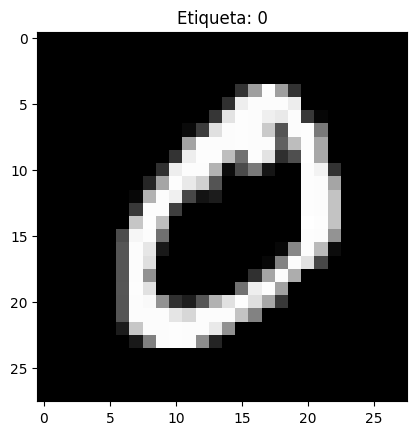

In [ ]:
image, label = train_dataset[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Etiqueta: {label}")
plt.show()

Una vez con un conjunto de datos, vamos a ver las propiedades del problema que estamos trabajando ahora. Esta vez tenemos $|C|$ clases. Antes asumíamos una clase positiva (1) y una negativa (0). Podíamos moderlarlo en un único eje en el rango $[0,1]$. En ese contexto hemos visto que podemos intentar minimizar la función de entropia, cruzada binaria:

$$BCE(y_{pred}, y_{true}) = -(y_{true}log(y_{pred})+(1-y_{true})log(1-y_{pred}))$$

Esta función tiene un comportamiento llamativo. Si uno la observa ve que realmente la etiqueta verdadera ($y_{true}$) sirve como máscara de qué termino activar o desactivar. Si la clase verdadera es positiva (1), la BCE es $-log(y_{pred})$ y si es negativa, la BCE es $-log(1-y_{pred})$. Si entendemos $y_{pred}$ como una probabilidad, podemos decir que nuestro modelo predice la probabilidad de que un ejemplo $x$ sea de la clase positiva como $p_{pos}(x)=y_{pred}$ y que sea de la clase negativa $p_{neg}(x)=(1-y_{pred})$. Al final la BCE solo está calculando $-log(p_c(x))$ siendo $p_c$ la probabilidad de que el ejemplo $x$ pertenezca a una clase concreta.

Eso es perfectamente generalizable a más de dos clases. Dadas las clases posibles $C$ y un ejemplo $x$ que sabemos pertenece a la clase $y_{true} \in C$ (problema supervisado), la entropía cruzada puede definirse como:

$$CE(x) = -log(p_{y_{true}}(x))$$

La expresión general es incluso más sencilla que la binaria, ¿no? Pero para poder usar esta aproximación a la clasificación multiclase necesitamos que nuestro modelo prediga $p_{c}(x) \forall c \in C$ (una probabilidad para cada clase posible).

Esto nos obliga a cambiar la estrategia que seguíamos para la clasificación binaria. Ya no podemos tener un único valor de salida y ver si se acerca más al 0 o al 1. Ahora necesitamos una salida por cada clase. Nuestra capa de salida tendrá, por tanto, $|C|$ neuronas que tendrán resultados en el rango $[0,1]$. La salida de nuestro modelo estará en el rango $[0,1]^|C|$.

Si tenemos 10 clases como en el conjunto de datos MNIST, la salida será un vector de 10 valores entre el 0 y el 1. Para una clase concreta, el resultado ideal estará relaciondo con el orden que le demos a las clases en ese vector. En el MNIST las clases son números del 0 al 9, así que lo natural es asignarles el orden que les corresponde. Por tanto, la clase 3 tendría una salida ideal de nuestro modelo $(0,0,0,1,0,0,0,0,0,0)$. La 7, $(0,0,0,0,0,0,0,1,0,0)$. Esta representación de la clase se podría hacer igual si en vez de 10 números, nuestras clases fueran 10 animales. Simplemente decidiríamos que la primera clase corresponde a un animal, la segunda a otro, etc...

A codificar el número de una clase $c \in C$ como un vector de tamaño $|C|$ se le llama codificación *one hot* y es un concepto muy común en clasificación multiclase. En PyTorch es fácil realizarla:

In [ ]:
t = torch.tensor([0,1,2,3,4,5,6,7,8,9], dtype=torch.long)

F.one_hot(t)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

Podríamos pensar que para obtener con nuestro modelo una salida $[0,1]^{|C|}$, basta con tener $|C|$ neuronas clásicas en la capa de salida y usar la función de activación sigmoide en ellas. Eso es cierto, pero si queremos tratar nuestros resultados como probabilidades, tienen que parecerlo. Dadas $C$ clases, la teoría de la probabilidad dice que la suma de todas las probabilidades de todas las posibilidades que se pueden dar en un caso concreto deben sumar uno.

$$\sum_{c \in C} p_{c}(x) = 1$$

Ni más, ni menos. Uno. UNO.

Si simplemente usamos la función sigmoide en cada neurona de salida, el vector estará en $[0,1]^{|C|}$, pero nada nos asegure que sumar las probabilidades predichas para cada clase sumará 1. De hecho, lo más probable es que no sumen 1.

¿Qué hacemos entonces? Bueno... Es el momento de presentar otra función de activación. La función Softmax.

Dado un vector $\mathbf{x}=(x_{1},x_{2},...,x_{n})$, podemos definir la función softmax como:

$$softmax(x_{1},x_{2},...,x_{n}) = (\frac{e^{x_{1}}}{\sum_{i=1}^{n}e^{x_{i}}}, \frac{e^{x_{2}}}{\sum_{i=1}^{n}e^{x_{i}}},..., \frac{e^{x_{n}}}{\sum_{i=1}^{n}e^{x_{i}}})$$

Parece un poco rara, pero si analizamos esta función podemos ver que es bastante sencilla de entender. Si tenemos un vector con $n$ entradas (en nuestra aplicación una por clase, $n=|C|$), la función softmax nos devolverá un vector de tamaño $n$. Dada una componente del vector $x_{j}$, la función softmax la transforma en $\frac{e^{x_{j}}}{\sum_{i=1}^{n}e^{x_{i}}}$. Vamos a simplificar esa expresión para que no haya exponenciales haciendo la sustitución $z_{k}=e^{x_{k}}$. La expresión queda como $\frac{z_{j}}{\sum_{i=1}^{n}z_{i}}$. Esa expresión no es más que una normalización para transformar los resultados $k_{j}$ al rango $[0,1]$. Pero es que además, si sumamos todos los resultados de ese vector (mantenemos la sustitución $z_{k}=e^{x_{k}}$ por simplicidad):

$$\sum_{i=j}^{n} \frac{z_{j}}{\sum_{i=1}^n z_{i}} = \frac{1}{\sum_{i=1}^n z_{i}}\sum_{j=1}^{n} z_{j} = \frac{\sum_{j=1}^{n} z_{j}}{\sum_{i=1}^n z_{i}} = 1$$

La igualdad anterior se mantiene aunque deshagamos la sustitución $z_{k}=e^{x_{k}}$:

$$\sum_{j=1}^{n} \frac{e^{x_{j}}}{\sum_{i=1}^n e^{x_{i}}}=1$$

Parece que podríamos interpretar que $\frac{e^{x_{j}}}{\sum_{i=1}^n e^{x_{i}}}$ es la probabilidad de la j-ésima clase.

Es fácil verlo en PyTorch:


In [ ]:
x = 10*torch.rand(10)
print(x)
softmax = torch.nn.Softmax(dim=0)
s = softmax(x)
print(s)
print(s.sum())

tensor([4.5512, 0.7030, 5.5110, 1.7672, 6.9340, 1.0457, 8.2883, 1.8395, 4.6079,
        9.4951])
tensor([5.0511e-03, 1.0767e-04, 1.3189e-02, 3.1211e-04, 5.4731e-02, 1.5169e-04,
        2.1203e-01, 3.3551e-04, 5.3455e-03, 7.0875e-01])
tensor(1.)


¿Por qué trabajar con $e^{x_{j}}$ en lugar de con $x_{j}$? Bueno, la función exponencial tiene dos propiedades interesantes. Para empezar, $\frac{x_{j}}{\sum^n_{i=0}x_{i}}$ solo tendrá resultados en $[0,1]$ si $\forall x_{i} \in (x_{1},...,x_{n}), x_{i}\geq 0$. Sin embargo, $\forall m \in \mathbb{R},  e^{m} \geq 0$, así que $\forall x_{i} \in (x_{1},...,x_{n}), e^{x_{i}} \geq 0$. La exponencial nos permite la normalización, aunque ese problema se podría haber solucionado de otra manera. La exponencial tiene una propiedad más: que crece exponencialmente (valga la redundencia). Si asumimos que el vector de entrada $\mathbf{x}$ está en $\mathbb{R}^n$ y tenemos dos de sus componentes $x_{i} \geq 0$ y $x_{j} \geq 0$. Si $x_{i}>x_{j}$, $x_{i}-x_{j} < e^{x_{i}}- e^{x_{j}}$. O dicho en términos más simples, la exponencial hará que los números más grandes (mayores que 0) aumenten su diferencia respecto a los demás, por lo que luego al normalizarlos entre sí favorecemos que un valor destaque sobre el resto. Este comportamiento es deseable porque asumimos que solo puede haber una clase correcta.

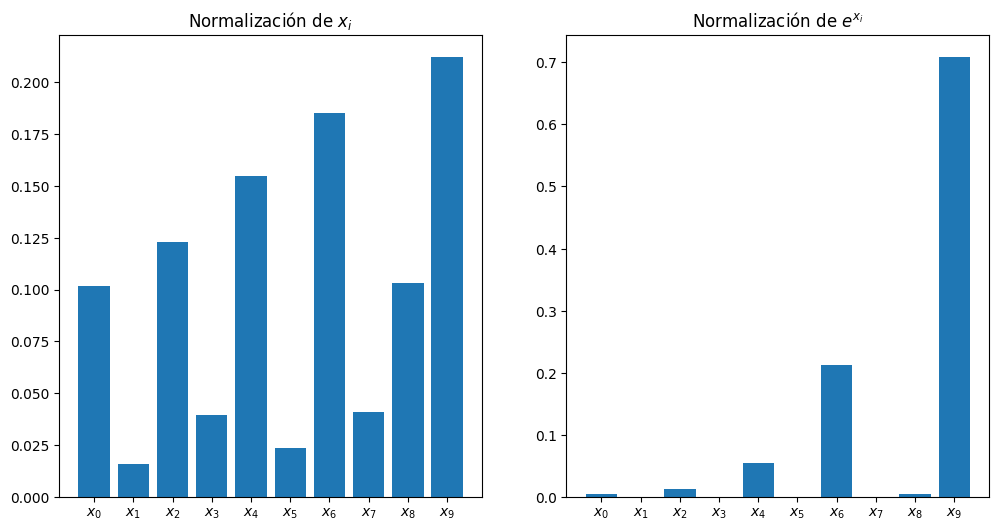

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

norm_x = x/x.sum()
etiquetas = [f'$x_{i}$' for i in range(x.numel())]
# Crear el gráfico
ax1.bar(etiquetas, norm_x)
ax1.set_title("Normalización de $x_i$")
ax2.bar(etiquetas, s)
ax2.set_title("Normalización de $e^{x_{i}}$")

# Mostrar el gráfico
plt.show()

Recapitulemos. Para empezar, a aprtir de la generalización de la entropia cruzada binaria (BCE) hemos concluido la entropía cruzada (CE) aplicable al caso de un número arbitrario de $n=|C|$ clases. De ahí hemos concluido el interés de representar cada clase como un vector de $n$ probabilidades. para obtener un vector de $n$ probabilidades con una red neuronal, construimos un modelo con $n$ salidas y a esa capa de salida aplicamos la función softmax para que el vector resultante cumpla las propiedades más básicas de la probabilidad.

Ahora uno podría plantearse que, igual que en el caso binario, se podría usar la aproximación de las probabilidades ignorando la función de entropia cruzada y usar una función basada en la distancia como hacíamos en los problemas de regresión.

Por poder, se puede, pero más allá de las propiedades interesantes de la entropia respecto al gradiente que comentamos para el caso binario (que siguen aplicando), hay un comportamiento antiintuivo en la implementación técnica de las funciones L1 y MSE.

Si tenemos los vectores (predición de un modelo y salida objetivo de un ejemplo) $y_{pred}=(1,0)$ y $y_{true}=(0,1)$, uno podría interpretar que el error entre ellos es la distancia entre uno y otro interpretándolos como puntos en el espacio. Es la generalización de lo que hacemos solo para 1 dimensión. Esa distancia entre $y_{pred}$ y $y_{true}$ para el caso de 2 dimensiones nos la da el Teorema de Pitagoras y es $\sqrt{2}$, así que con el error absoluto podríamos tomarla tal cuál y el cuadrático sería 2. Y si los vectores fueran $y_{pred}=(1,0,0)$ y $y_{true}=(0,1,0)$ intuitivamente pensaríamos que las distancias se mantienen. Al fin y al cabo añadir otra dimensión no cambia que los dos puntos están en el mismo plano.

Sin embargo, ese no es el cálculo que realizan las funciones L1 y MSE de PyTorch. Estas funciones calculan el error elemento a elemento y hacen la media. ¡Eso implica que aumentar el número de dimensiones puede reducir el error en la aplicación de clasificación! El MSE entre $y_{pred}$ y $y_{true}$ en el primer caso es $\frac{1^2+1^2}{2}=1$, mientras que en el segundo caso es $\frac{1^2+1^2+0^2}{2}=\frac{2}{3}$. Sin embargo, intuitivamente el error de clasificación que se está cometiendo es el mismo. La entropía cruzada no tiene en cuenta el número total de clases, solo el error que se comete en la clase objetivo, así que no tiene este problema.

Vamos a verlo en código:

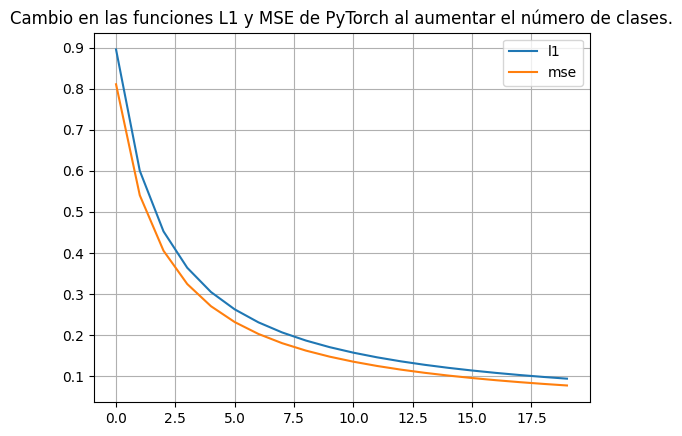

In [ ]:
N=20

l1_loss_list = []
mse_loss_list = []

l1 = nn.L1Loss()
mse = nn.MSELoss()

for i in range(N):
  pred = torch.tensor([[0.8]+(i+1)*[0.2/(N+1)]], dtype=torch.float)
  target = torch.tensor([(i+1)*[0]+[1]], dtype=torch.float)

  l1_loss_list.append(l1(pred,target))
  mse_loss_list.append(mse(pred,target))

fig, ax = plt.subplots()
ax.plot(range(N), l1_loss_list, label="l1")
ax.plot(range(N), mse_loss_list, label="mse")
plt.title("Cambio en las funciones L1 y MSE de PyTorch al aumentar el número de clases.")

ax.legend()
ax.grid()

plt.show()

Vamos a ver cómo se puede en PyTorch la softmax en combianción con la entropía cruzada, pero antes vamos a introducir una utilidad nueva: la parada temprana (*early stopping*). El concepto es sencillo: poner unas condiciones de parada del bucle de entrenamiento que lo puedan detener antes de llegar al número de épocas indicado para evitar el sobreentrenamiento. Las codniciones de parada pueden ser muy diversas, pero vamos a implementar uno bastante genérico.

In [ ]:
class Early_Stop():
  def __init__(self, patience=5, delta=0):
    self.patience = patience
    self.delta = delta
    self.best_val_loss = None
    self.no_val_improvement_times = 0
    self.stop = False

  def check_stop(self, val_loss):
    if self.best_val_loss is None or (val_loss + self.delta) < self.best_val_loss:
      self.best_val_loss = val_loss
      self.no_val_improvement_times = 0
    else:
      self.no_val_improvement_times += 1
      self.stop = self.no_val_improvement_times >= self.patience

Esencialmente la clase lo que hace es almacenar el mejor valor de error en validación y, si después de un número de pasos de validación definidos por la *paciencia* no hay mejora, asumimos que debe pararse el entrenamiento. El valor delta es el margen mínimo de mejora que debe haber para que consideremos una mejora genuina (por evitar que  mejoras despreciables reinicien el contador).

In [ ]:
def learning_loop_for_classification_with_early_stopping(train_dataloader, val_dataloader, model, epochs, loss_fn, learning_rate, optimizer, validation_freq, early_stop):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []

  opt = optimizer(
    model.parameters(),
    lr=learning_rate
  )

  with tqdm(range(epochs), desc="epoch:") as pbar:
    for epoch in pbar:
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        y_pred = model(x_true)                              # Forward
        opt.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        opt.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            y_val_pred = model(x_val_true)

            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_acc_list.append(val_correct_answers/float(val_set_size))

        early_stop.check_stop(val_loss)
        if early_stop.stop:
          print("Early Stop.")
          break

  return model, epoch_loss_list, val_loss_list, val_acc_list

Nótese que, aunque ya no podemos aplicar directamente conceptos de clasificación binaria como Verdadero Positivo, Verdader Negativo, Falso Positivo o Falso Negativo debido a que no tenemos clase positiva y negativo, podemos seguir calculando el *accuracy* del modelo.


Podemos usar la entropía cruzada en PyTorch con torch.nn.CrossEntropyLoss(). Toma como primer argumento la salida **previa softmax** para cada clase generadas por el modelo para cada ejemplo y como segundo argumento un vector con la clase objetivo para cada ejemplo. Internamente calcula la softmax.

In [ ]:
batch_size = 256
learning_rate = 1e-3
epochs = 1001
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD
validation_freq = 5
patience = 5
delta = 0.01

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28,64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64,4)
)

early_stop = Early_Stop(patience = patience,
                        delta = delta)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification_with_early_stopping(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    learning_rate,
    optimizer,
    validation_freq = validation_freq,
    early_stop = early_stop)

Número de parámetros 50500


epoch::  13%|█▎        | 130/1001 [08:10<54:46,  3.77s/it, loss=0.13388492166996002]

Early Stop.


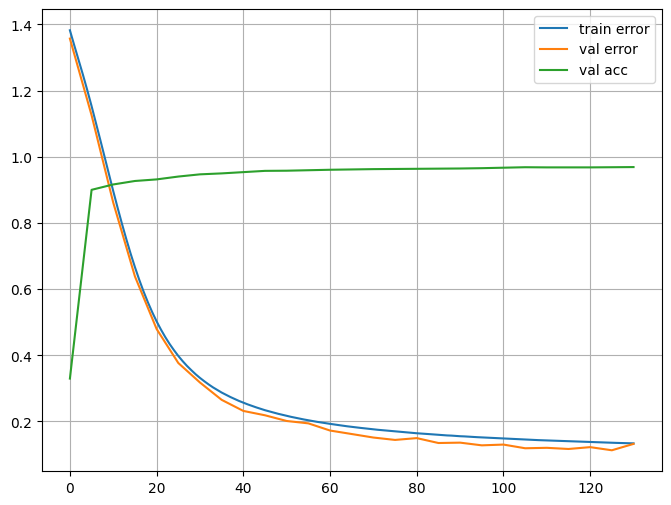

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), train_loss_list, label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), val_loss_list, label="val error")
plt.plot(range(0, validation_freq*len(val_acc_list), validation_freq), val_acc_list, label="val acc")
plt.legend()
plt.grid(True)
plt.show()

El *Early Stopping* ha parado ele ntrenamiento tras 130 épocas. Quizás podríamos beneficiarnos de un entrenamiento más largo (bajando el delta del *Early Stopping*), pero los cálculos en CPU lo alargan demasiado como para un ejemplo.

La matriz de confusión para problemas multiclase suele ser bastante útil para hacernos una ídea de cómo funciona el sistema.

Nótese que el resultado de nuestro modelo no va a ser una probabilidad porque la softmax la calcula internamente la función de pérdida. Esto es antiintuitivo porque si queremos el vector de probabilidades tenemos que aplciar la función softmax nosotros mismos después de aplicar el modelo.

Para obtener la matriz de confusión basta con quedarnos con la clase que haya tenido el valor más alto (que es la que tendría el valor más alto tras la softmax).

torch.Size([256, 4])
torch.Size([256])
torch.Size([2064])
torch.Size([2064])


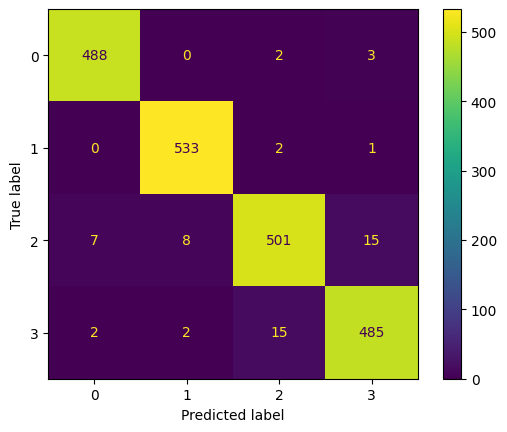

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

y_pred = []
y_test = []
for val_x_true, val_y_true in test_dataloader:
  y_test.append(val_y_true)
  y_pred.append(model(val_x_true).detach())

print(y_pred[0].shape)
print(y_test[0].shape)
y_test = torch.cat(y_test)
y_pred = torch.argmax(torch.cat(y_pred), dim=-1)
print(y_pred.shape)
print(y_test.shape)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

Aunque aplicar la entropía cruzada en combinación con una capa de salida softmax es la aproximación más habitual para los problemas de clasificación, tiene un problema: calcular los valores de la función exponencial puede llevar a errores numéricos debido a números demasiado grandes. Además, si lo hacemos siguiendo la implementación de PyTorch no tenemos la softmax integrada en el modelo.

In [ ]:
input = torch.linspace(0, 100, 100)
exp_output = torch.exp(input)
print(exp_output)

tensor([1.0000e+00, 2.7459e+00, 7.5398e+00, 2.0704e+01, 5.6849e+01, 1.5610e+02,
        4.2864e+02, 1.1770e+03, 3.2318e+03, 8.8742e+03, 2.4368e+04, 6.6910e+04,
        1.8373e+05, 5.0449e+05, 1.3853e+06, 3.8038e+06, 1.0445e+07, 2.8680e+07,
        7.8752e+07, 2.1624e+08, 5.9378e+08, 1.6304e+09, 4.4770e+09, 1.2293e+10,
        3.3756e+10, 9.2690e+10, 2.5451e+11, 6.9887e+11, 1.9190e+12, 5.2694e+12,
        1.4469e+13, 3.9730e+13, 1.0909e+14, 2.9956e+14, 8.2255e+14, 2.2586e+15,
        6.2019e+15, 1.7030e+16, 4.6761e+16, 1.2840e+17, 3.5257e+17, 9.6813e+17,
        2.6584e+18, 7.2995e+18, 2.0044e+19, 5.5037e+19, 1.5113e+20, 4.1497e+20,
        1.1395e+21, 3.1288e+21, 8.5915e+21, 2.3591e+22, 6.4778e+22, 1.7787e+23,
        4.8842e+23, 1.3411e+24, 3.6826e+24, 1.0112e+25, 2.7766e+25, 7.6243e+25,
        2.0935e+26, 5.7486e+26, 1.5785e+27, 4.3343e+27, 1.1902e+28, 3.2680e+28,
        8.9736e+28, 2.4640e+29, 6.7659e+29, 1.8578e+30, 5.1014e+30, 1.4008e+31,
        3.8464e+31, 1.0562e+32, 2.9001e+

No hemos impuesto ninguna restricción a las salidas del modelo (las entradas que tendría la función softmax), así que es relativamente fácil que tenga como entrada un valor que provoque un desbordamiento del rango. Pese a que PyTorch tenga una implementación que procure la estabilidad de la softmax, también ofrece una vía numéricamente más estable para realizar exactamente el mismo proceso.

Consiste en trabajar con el logaritmo de la Softmax usando la función de activación torch.nn.LogSoftmax(). Con ella, en lugar del vector de probabilidades, se obtienen los logaritmos de las probabilidades calculados de manera numéricamente más estable. Como función de pérdida en ese caso se utiliza la función *Negative Log Likelihood Loss* (torch.nn.NLLLoss()) que esencialmente toma el logritmo de la probabilidad estimada para la clase adecuada y lo multiplica por -1.

Las dos combinaciónes (CrossEntropyLoss y LogSoftmax + NLLLoss) realizan un calculo matemáticamente equivalente (si se usan de esta manera). Con esta aproximación, si queremos las probabilidades estimadas debemos acordarnos de anular le logaritmo (aplicando la exponencial).

Vamos a ejecutarlo:

In [ ]:
batch_size = 256
learning_rate = 1e-3
epochs = 1001
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD
validation_freq = 5
patience = 5
delta = 0.01

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28,64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64,4),
    torch.nn.LogSoftmax(dim=1)
)

early_stop = Early_Stop(patience = patience,
                        delta = delta)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification_with_early_stopping(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    learning_rate,
    optimizer,
    validation_freq = validation_freq,
    early_stop = early_stop)

Número de parámetros 50500


epoch::  15%|█▌        | 155/1001 [10:10<55:32,  3.94s/it, loss=0.12585075199604034]

Early Stop.


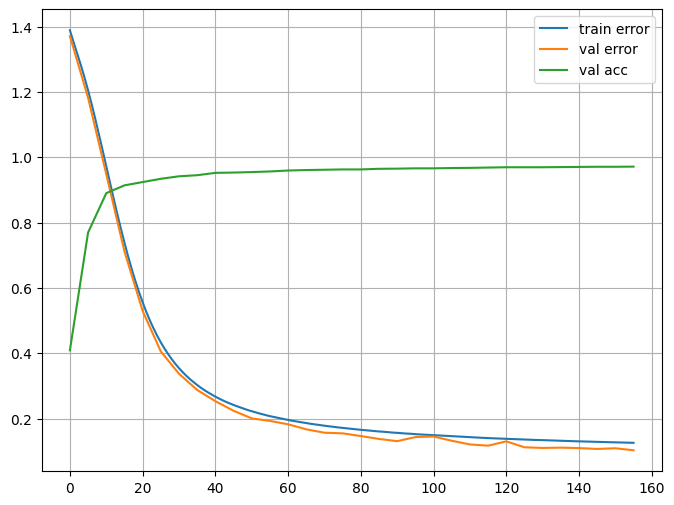

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), train_loss_list, label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), val_loss_list, label="val error")
plt.plot(range(0, validation_freq*len(val_acc_list), validation_freq), val_acc_list, label="val acc")
plt.legend()
plt.grid(True)
plt.show()

Una vez más sabemos que la clase con más valor será el argumento del valor máximo auqnue las salidas del modelo sean el logaritmo de la probabilidad.

torch.Size([256, 4])
torch.Size([256])
torch.Size([2064])
torch.Size([2064])


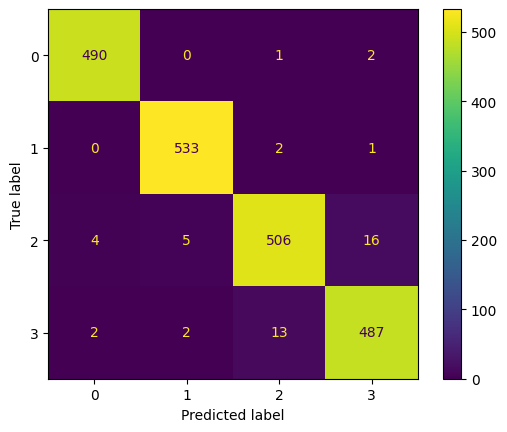

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

y_pred = []
y_test = []
for val_x_true, val_y_true in test_dataloader:
  y_test.append(val_y_true)
  y_pred.append(model(val_x_true).detach())

print(y_pred[0].shape)
print(y_test[0].shape)
y_test = torch.cat(y_test)
y_pred = torch.argmax(torch.cat(y_pred), dim=-1)
print(y_pred.shape)
print(y_test.shape)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

En ninguna de las dos aproximaciones necesitamos utilizar explícitamente la codificación *one hot* para las etiquetas de los conjuntos de datos porque PyTorch lo asume de forma implícita para estas funciones.